Roll Numbers

24100049
24100032
24100192
24100072
24100181

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U sentence-transformers                         #installing the sentence-transformers module on Colab (remove for VS Code)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.9 MB/s 
     |████████████████████████████████| 5.8 MB 69.3 MB/s 
     |████████████████████████████████| 1.3 MB 43.9 MB/s 
     |████████████████████████████████| 182 kB 76.6 MB/s 
     |████████████████████████████████| 7.6 MB 64.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=5a77cc052c05c1e0ab249fbd7d95a756f165fb8926432254958a514d518ac8f4
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
#importing relevant libraries
import pandas as pd
import numpy as np
from string import punctuation
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV,cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import BaggingClassifier, VotingClassifier, AdaBoostClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV


# Reading Data

In [135]:
df = pd.DataFrame(columns=["tweet", "label"])
df.head()

,tweet,label


In [146]:
labels = ["bill gates", "downing street", "mia mottley", "roger federer", "white house"]                                                    #creating list of all possible output labels
files = ["BillGates_task1.csv", "downingstreet_task1.csv", "miaamormottley_task1.csv", "rogerfederer_task1.csv", "WhiteHouse_task1.csv"]    #creating list of all members' .csv files

for file, label in zip(files, labels):                                                                                                      #iterating through files and output labels (each file corresponds to a different output label)
    tweets_df = pd.read_csv(f"/content/drive/My Drive/ML/project/{file}")                                                                                                           #reading file with pandas
    tweets_df = tweets_df.rename(columns={"Tweet": "tweet", "Tweets": "tweet", "tweets": "tweet"})                                          #renaming dataframe column names where required for uniformity
    tweets_df["label"] = label                                                                                                              #storing appropriate label with this data

    df = pd.concat([tweets_df.iloc[:, [-2, -1]], df], )                                                                                     #concatenating this iteration's data into one big dataframe

In [ ]:
df.head()

,tweet,label
0,Hidden “junk” fees – like processing fees on c...,white house
1,"Under the Biden-Harris Administration, surpris...",white house
2,Get your updated COVID vaccine as soon as poss...,white house
3,President Biden’s Bipartisan Infrastructure La...,white house
4,.@POTUS signed the first major gun safety legi...,white house


In [ ]:
print("The dimensions of our cumulative dataframe are:", df.shape)                                                                          #printing dimensions of our final dataframe                                                                                                                                   

The dimensions of our cumulative dataframe are: (5303, 2)


In [ ]:
print("Counts:")                                                                                                                            #printing the number of records per label (we scraped 1000 tweets each)
for label in df["label"].unique():                                                                                                          #iterating through all the unique labels in our dataframe 
    print(f"{label}: {sum(df['label'] == label)}")                                                                                          #printing number of entries with this label

Counts:
white house: 1001
roger federer: 1001
mia mottley: 1300
downing street: 1001
bill gates: 1000


# Data Cleaning

In [ ]:
def clean_data(series):
    stop_words = ["i", "i'm", "me", "my", "myself", "we", "our", "ours", "ourselves",
              "you", "you're", "you've", "you'll", "you'd", "your", "yours", "yourself",
              "yourselves", "he", "him", "his", "himself", "she", "she's", "her", "hers",
              "herself", "it", "it's", "its", "itself", "they", "them", "their", "theirs",
              "themselves", "what", "which", "who", "whom", "this", "that", "that'll",
              "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
              "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
              "the", "and", "but", "if", "or", "because", "as", "until", "while", "of",
              "at", "by", "for", "with", "about", "against", "between", "into", "through",
              "during", "before", "after", "above", "below", "to", "from", "up",
              "down", "in", "out", "on", "off", "over", "under", "again", "further", "then",
              "once", "here", "there", "when", "where", "why", "how", "all", "any", "both",
              "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not",
              "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will",
              "just", "don", "don't", "should", "should've", "now", "d", "ll", "m", "o",
              "re", "ve", "y", "ain", "aren", "aren't", "couldn", "couldn't", "didn",
              "didn't", "doesn", "doesn't", "hadn", "hadn't", "hasn", "hasn't", "haven",
              "haven't", "isn", "isn't", "ma", "mightn", "mightn't", "mustn", "mustn't",
              "needn", "needn't", "shan", "shan't", "shouldn", "shouldn't", "wasn",
              "wasn't", "weren", "weren't", "won", "won't", "wouldn", "wouldn't", "b", "c",
              "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s",
              "t", "u", "v", "w", "x", "y", "z"]
    
    # tags_accounts = "(@|#)\w*"
    twitter_images = "https://t.co/[a-zA-Z0-9]{10}"
    non_ascii = "[^\x00-\x7F]+"
    punctuations = f"[{punctuation}]"
    numbers = "\d+"
    
    series = series.str.lower()                                             #convering to lower case
    series = series.str.split().str.join(" ")                               
    series = series.str.replace(twitter_images, " ", regex=True)            #removing twitter images
    series = series.str.replace(numbers, " ", regex=True)                   #removing numbers
    series = series.str.replace(punctuations, " ", regex=True)              #removing punctuations
    series = series.apply(lambda tweet: " ".join([word for word in tweet.split() if word not in stop_words]))     #removing stop words

    return series

In [137]:
df["tweet"] = clean_data(df["tweet"])
df = df[df["tweet"].str.len() > 0]

In [ ]:
print("Counts:")                                                                                                                            #printing the number of records per label (we scraped 1000 tweets each)
for label in df["label"].unique():                                                                                                          #iterating through all the unique labels in our dataframe 
    print(f"{label}: {sum(df['label'] == label)}")                                                                                          #printing number of entries with this label

Counts:
white house: 996
roger federer: 956
mia mottley: 1251
downing street: 1000
bill gates: 998


# Shuffle Data

In [ ]:
df = df.sample(frac=1, random_state=0)

In [ ]:
df.head(10)

,tweet,label
833,thanks hit today david goffin ☀️🎾👍🏼,roger federer
988,th sitting parliament th january,mia mottley
638,black borrowers latino borrowers pell grant re...,white house
437,i’m grateful joined borisjohnson today highlig...,bill gates
334,biden harris administration taken significant ...,white house
514,learning dance 🕺 moves zambia 🇿🇲 visiting comm...,roger federer
42,president biden asean leaders began new era co...,white house
568,presenting economic stabilization programme fe...,mia mottley
1076,th sitting parliament th november,mia mottley
148,malawi united states new cases polio reminder ...,bill gates


In [ ]:
df.shape

(5201, 2)

# Train Test Split

In [148]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=0)

In [ ]:
print("Train:", train_df.shape)
print("Test:", test_df.shape)

Train: (4160, 2)
Test: (1041, 2)


# Feature Extraction

In [ ]:
# getting bag of words from the complete data set
def get_bow(dataset):
    return list(set([word for sentence in dataset for word in sentence.split()]))

In [ ]:
# getting bag of words feature vector for each datapoint
def get_features(dataset, bow):
    word_to_idx = dict(map(lambda pair: (pair[1], pair[0]), enumerate(bow)))
    features = np.zeros((len(dataset), len(bow)), dtype=int)
    
    for idx, sentence in enumerate(dataset):
        for word in sentence.split():
            word_idx = word_to_idx.get(word)
            if word_idx:
                
                features[idx][word_idx] += 1
            
    return features

## BOW

In [ ]:
bow = get_bow(train_df["tweet"])
bow[:10]

['recognise',
 'andreagassi',
 'immovable',
 'taco',
 'retains',
 'congratulations',
 'interaction',
 'tail',
 'quarters',
 'people…']

In [ ]:
len(bow)

10369

In [ ]:
x_train_bow = get_features(train_df["tweet"], bow)
x_train_bow[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y_train_bow = train_df["label"].to_numpy()
y_train_bow[:10]

array(['white house', 'downing street', 'downing street', 'white house',
       'roger federer', 'white house', 'white house', 'roger federer',
       'downing street', 'white house'], dtype=object)

In [ ]:
x_test_bow = get_features(test_df["tweet"], bow)
x_test_bow[:10, :10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
y_test_bow = test_df["label"].to_numpy()
y_test_bow[:10]

array(['white house', 'mia mottley', 'white house', 'downing street',
       'mia mottley', 'white house', 'roger federer', 'downing street',
       'bill gates', 'mia mottley'], dtype=object)

## Embeddings

In [149]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [150]:
x_train_emb = np.apply_along_axis(model.encode, 0, train_df["tweet"].to_numpy())
x_train_emb[:10, :10]

array([[-0.05045085,  0.02066581, -0.0006325 , -0.02585806,  0.01583238,
         0.04289998, -0.01050459,  0.08606196, -0.03148473, -0.01451582],
       [ 0.0119578 ,  0.03023548,  0.06557005, -0.03132365,  0.04301972,
        -0.01227523,  0.14998257, -0.00020905, -0.00371817, -0.05960565],
       [-0.03108075,  0.03790576, -0.00723126, -0.12551828, -0.02123903,
         0.05617909,  0.06786272, -0.01183398,  0.10013072,  0.10389531],
       [-0.05222638,  0.06110745,  0.0188529 ,  0.0060043 ,  0.03062148,
        -0.02923474,  0.03359567,  0.03266168, -0.01654871, -0.03119116],
       [-0.03492494,  0.07810794,  0.04323696,  0.04384541,  0.03969851,
         0.02037491,  0.05025155,  0.06419948,  0.03508688, -0.06727882],
       [-0.01982851, -0.00253645, -0.02690459, -0.07361098,  0.05041354,
        -0.03728132, -0.03115604,  0.02072747, -0.01646523,  0.06172785],
       [ 0.02240058, -0.0005009 , -0.00232304,  0.03222509, -0.08174729,
         0.08967858, -0.07509478, -0.02436958

In [151]:
y_train_emb = train_df["label"].to_numpy()
y_train_emb[:10]

array(['downing street', 'bill gates', 'roger federer', 'downing street',
       'roger federer', 'mia mottley', 'mia mottley', 'bill gates',
       'roger federer', 'mia mottley'], dtype=object)

In [152]:
x_test_emb = np.apply_along_axis(model.encode, 0, test_df["tweet"].to_numpy())
x_test_emb[:10, :10]

array([[-0.03651261,  0.05535118,  0.06270132,  0.0078628 ,  0.03001651,
        -0.01216754,  0.02582772,  0.05276696, -0.00160708, -0.08919734],
       [-0.12798719,  0.02279217, -0.01489823,  0.00943897, -0.05618929,
        -0.06210653,  0.04840302,  0.04482104, -0.08614184, -0.04460581],
       [-0.07813361, -0.02027079,  0.01346625, -0.0136258 ,  0.02597586,
         0.0444963 , -0.08653998, -0.04840976, -0.05477982, -0.04656878],
       [-0.04223031,  0.02891875,  0.05291695, -0.00635327,  0.02889627,
        -0.00998626,  0.02527368,  0.00454401, -0.04495877, -0.05560796],
       [ 0.03763169,  0.04605574,  0.06934774, -0.03299649, -0.02485377,
        -0.05578651,  0.01541493, -0.06921703, -0.06629182,  0.01350862],
       [-0.07480537,  0.01951044,  0.00454768, -0.00116415,  0.08456881,
         0.05028231,  0.00857742,  0.07878318, -0.03409591,  0.0399546 ],
       [-0.02774523,  0.03519297,  0.01452091, -0.04063994, -0.01418096,
        -0.04596282, -0.09518705, -0.03536091

In [153]:
y_test_emb = test_df["label"].to_numpy()
y_test_emb[:10]

array(['bill gates', 'roger federer', 'bill gates', 'roger federer',
       'roger federer', 'mia mottley', 'bill gates', 'white house',
       'downing street', 'bill gates'], dtype=object)

# Modelling

Evaluation Function

In [ ]:
def evaluate(y_true, y_pred):
    cf_mat = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred,output_dict=True)
    # "{:.2f}".format(report['macro avg']['f1-score'])
    print("Accuracy:  ","{:.2f}".format(report['accuracy']*100))
    print("Precision: ", "{:.2f}".format(report['macro avg']['precision']*100))  
    print("Recall:    ","{:.2f}".format(report['macro avg']['recall']*100))
    print("F1-Score:  ","{:.2f}".format(report['macro avg']['f1-score']*100))           #printing classification report
    
    labels = ['bill gates', 'downing street', 'mia mottley', 'roger federer', 'white house']
    
    plt.figure(figsize=(10, 8))
    ax = plt.subplot()
    sns.heatmap(cf_mat, annot=True, fmt="g", ax=ax, cmap='mako_r')      #printing confusion matrix
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

Cross Validation Function

In [ ]:
def cross_validate_plot(model, x, y, folds=5):
    metrics = cross_validate(model, x, y, return_train_score=True)        #runing cross validation

    metric_df = pd.DataFrame({"training": metrics["train_score"], "validation": metrics["test_score"], "fold": list(range(1, folds+1))})
    metric_df = pd.melt(metric_df, id_vars=["fold"], value_vars=["training", "validation"], var_name="type", value_name="accuracy")

    plt.figure(figsize=(10, 8))
    sns.lineplot(data=metric_df, x="fold", y="accuracy", hue="type")        
    plt.xlabel("folds")
    plt.show()

# KNN

## BOW

Tuning


In [ ]:
# using GridSearhCV to tune hyperparameters for KNN using Bag of word feature set
params = {
    "n_neighbors": list(range(1, 10)), 
    "weights": ["uniform", "distance"],         #tuning number of neighbors, weights and p
    "p": [1, 2]
}

knn = KNeighborsClassifier()

clf = GridSearchCV(knn, params)
search = clf.fit(x_train_bow[:500], y_train_bow[:500])
search.best_params_

{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

Cross Validation


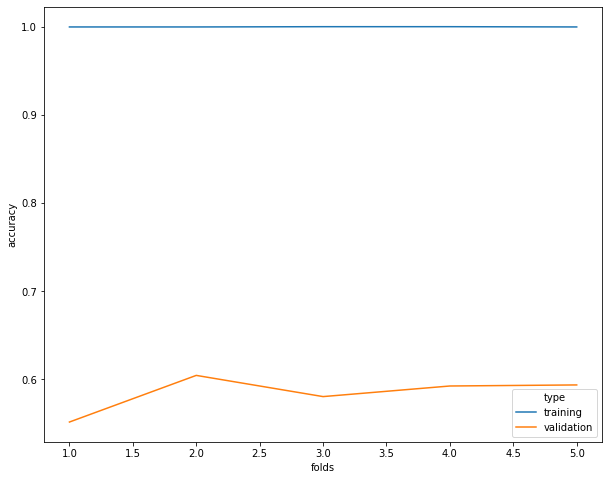

In [ ]:
knn=KNeighborsClassifier(n_neighbors=3,p=2,weights='distance')
cross_validate_plot(knn,x_train_bow,y_train_bow)

Running final Model

Accuracy:   64.65
Precision:  72.58
Recall:     64.04
F1-Score:   63.61


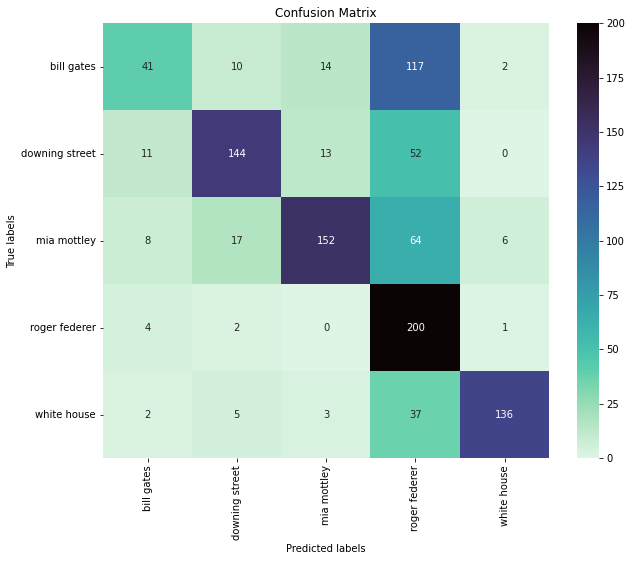

In [ ]:
# runing model with previously found best parameters
model = KNeighborsClassifier(n_neighbors=3, weights="distance", p=2)
model.fit(x_train_bow, y_train_bow)

y_pred = model.predict(x_test_bow)
evaluate(y_test_bow, y_pred)

## Embeddings

Tuning


In [ ]:
# using GridSearhCV to tune hyperparameters for KNN using Embedding feature set
params = {                                        
    "n_neighbors": list(range(1, 10)),                        #tuning number of neighbors, weights and p
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

knn = KNeighborsClassifier()

clf = GridSearchCV(knn, params)
search = clf.fit(x_train_emb[:500], y_train_emb[:500])
search.best_params_

{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

Cross Validation

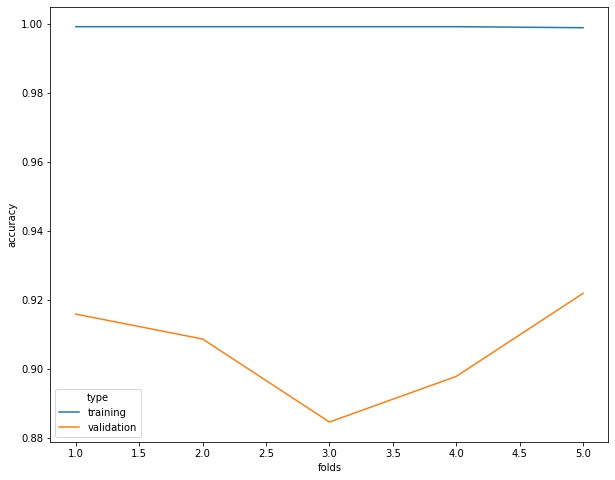

In [ ]:
knn=KNeighborsClassifier(weights="distance",p=1,n_neighbors=4)
cross_validate_plot(knn,x_train_emb,y_train_emb)



Running Final Model

Accuracy:   91.74
Precision:  91.55
Recall:     91.96
F1-Score:   91.69


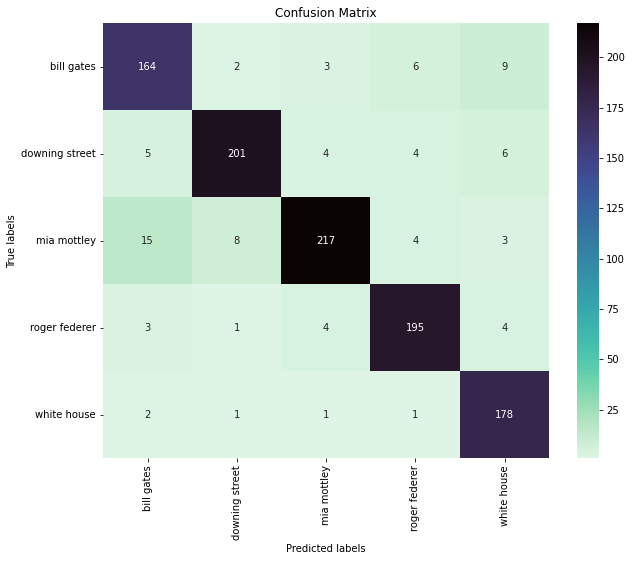

In [ ]:
# runing model with previously found best parameters
model = KNeighborsClassifier(n_neighbors=4, weights='distance', p=1)
model.fit(x_train_emb, y_train_emb)

y_pred = model.predict(x_test_emb)
evaluate(y_test_emb, y_pred)

## NNs

## BOW

Tuning

In [ ]:
# using GridSearhCV to tune hyperparameters for NN using Bag Of Words feature set

params = {                                                          #tuning activation function
    "activation": ['identity','logistic','tanh','relu']
    
}



nn=MLPClassifier(hidden_layer_sizes=(256, 256, 128, 64))

clf = GridSearchCV(nn, params)
search = clf.fit(x_train_bow[:500], y_train_bow[:500])
search.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

{'activation': 'tanh'}

Cross Validation

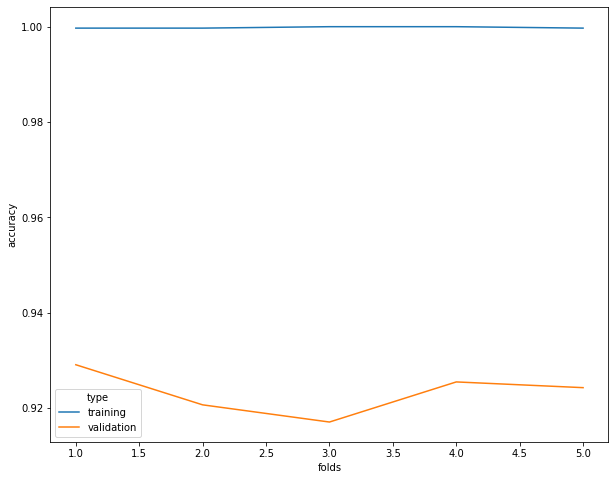

In [ ]:
nn=MLPClassifier(hidden_layer_sizes=(256, 256, 128, 64),activation='tanh')
cross_validate_plot(nn,x_train_bow,y_train_bow)


Runing Final Model

Accuracy:   93.37
Precision:  93.24
Recall:     93.48
F1-Score:   93.32


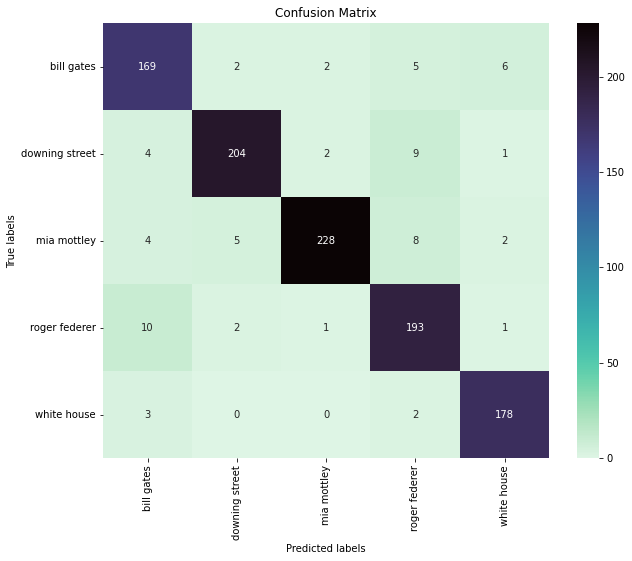

In [ ]:
# runing model with previously found best parameters
model = MLPClassifier(hidden_layer_sizes=(256, 256, 128, 64),activation='tanh')
model.fit(x_train_bow, y_train_bow)

y_pred = model.predict(x_test_bow)
evaluate(y_test_bow, y_pred)

# Embeddings

Tuning

In [ ]:
# using GridSearhCV to tune hyperparameters for NN using Embedding feature set

params = {                                                        #tuning activation function
    "activation": ['identity','logistic','tanh','relu']
    
}



nn=MLPClassifier(hidden_layer_sizes=(256, 256, 128, 64))

clf = GridSearchCV(nn, params)
search = clf.fit(x_train_emb[:500], y_train_emb[:500])
search.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'activation': 'relu'}

Cross Validation

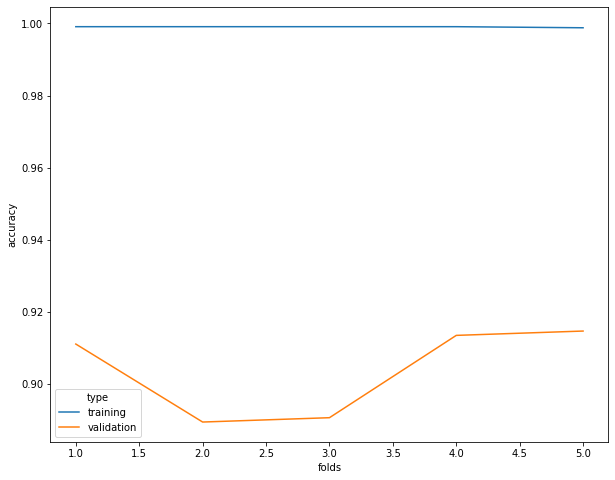

In [ ]:
nn=MLPClassifier(hidden_layer_sizes=(256, 256, 128, 64),activation='relu')
cross_validate_plot(nn,x_train_emb,y_train_emb)

Runing Final Model

Accuracy:   89.63
Precision:  89.60
Recall:     89.82
F1-Score:   89.69


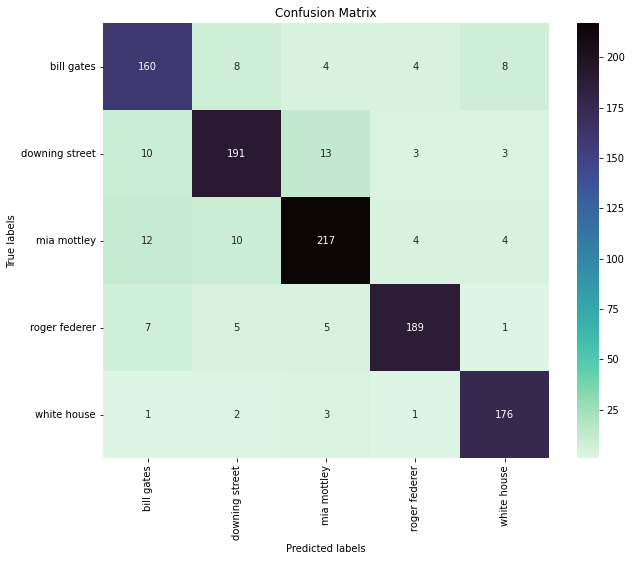

In [ ]:
# runing model with previously found best parameters
model = MLPClassifier(hidden_layer_sizes=(256, 128, 128),activation='relu')
model.fit(x_train_emb, y_train_emb)

y_pred = model.predict(x_test_emb)
evaluate(y_test_emb, y_pred)

## Ensemble Methods

## BOW

In [ ]:
# cross validation for finding best emsemble method using bag of words feature set
labels = ["Bagging", "Ada Boost", "Random Forest"]
metrics = []
methods = [BaggingClassifier, AdaBoostClassifier, RandomForestClassifier]

for method in methods:
    y_pred = cross_val_predict(method(), x_train_bow, y_train_bow)
    metrics.append(accuracy_score(y_train_bow, y_pred))

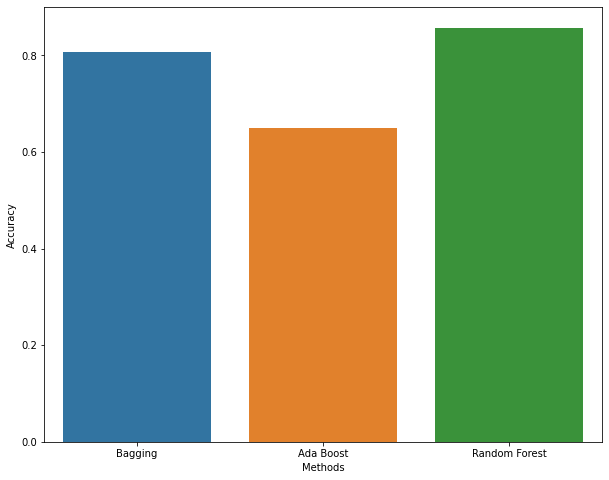

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x=labels, y=metrics)
plt.xlabel("Methods")
plt.ylabel("Accuracy")
plt.show()

## Tuning Random Forest

In [ ]:
# Random forest chosen as best emsemle method for bag of word feature set
# finding best parameters for random forest using bag of words feature set
params = {
    "n_estimators": np.linspace(100, 200, 11, dtype=int), 
    "max_depth": np.linspace(10, 120, 12, dtype=int),
    "max_features": ["sqrt", "log2", None]
}

model = RandomForestClassifier(random_state = 0)

clf = GridSearchCV(model, params)
search = clf.fit(x_train_bow[:500], y_train_bow[:500])
search.best_params_

{'max_depth': 80, 'max_features': 'log2', 'n_estimators': 180}

Accuracy:   90.01
Precision:  90.69
Recall:     90.00
F1-Score:   90.10


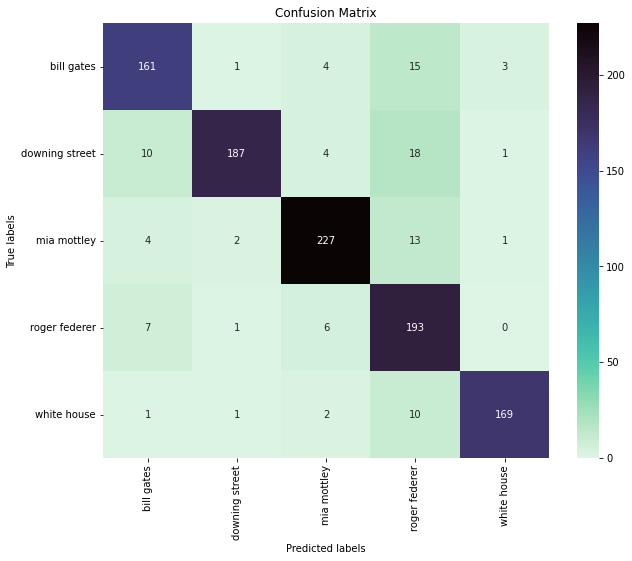

In [ ]:
# runing model with previously found best parameters
model = RandomForestClassifier(n_estimators=180, max_depth=80, max_features="log2")
model.fit(x_train_bow, y_train_bow)

y_pred = model.predict(x_test_bow)
evaluate(y_test_bow, y_pred)

## Embeddings

In [ ]:
# cross validation for finding best emsemble method using embedding feature set
labels = ["Bagging", "Ada Boost", "Random Forest"]
metrics = []
methods = [BaggingClassifier, AdaBoostClassifier, RandomForestClassifier]

for method in methods:
    y_pred = cross_val_predict(method(), x_train_emb, y_train_emb)
    metrics.append(accuracy_score(y_train_emb, y_pred))

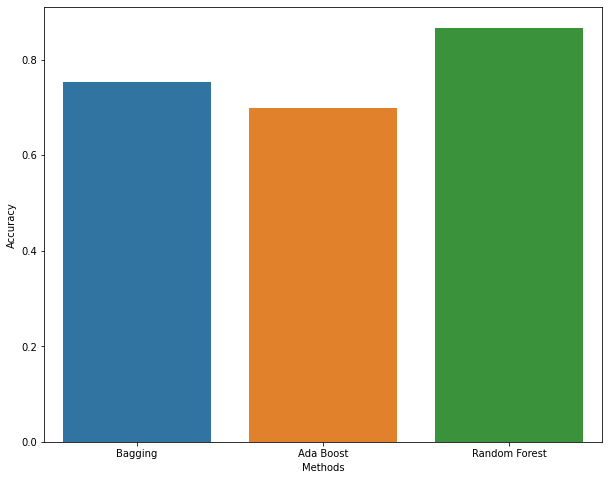

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x=labels, y=metrics)
plt.xlabel("Methods")
plt.ylabel("Accuracy")
plt.show()

## Tuning Random Forest

In [144]:
params = {
    "n_estimators": np.linspace(200, 350, 11, dtype=int), 
    "max_depth": np.linspace(60, 160, 12, dtype=int),
    "max_features": ["sqrt", "log2", None]
}

model = RandomForestClassifier(random_state = 0)

clf = RandomizedSearchCV(model, params)
search = clf.fit(x_train_emb[:500], y_train_emb[:500])
search.best_params_

{'n_estimators': 350, 'max_features': 'log2', 'max_depth': 132}

Accuracy:   91.15
Precision:  91.34
Recall:     91.26
F1-Score:   91.17


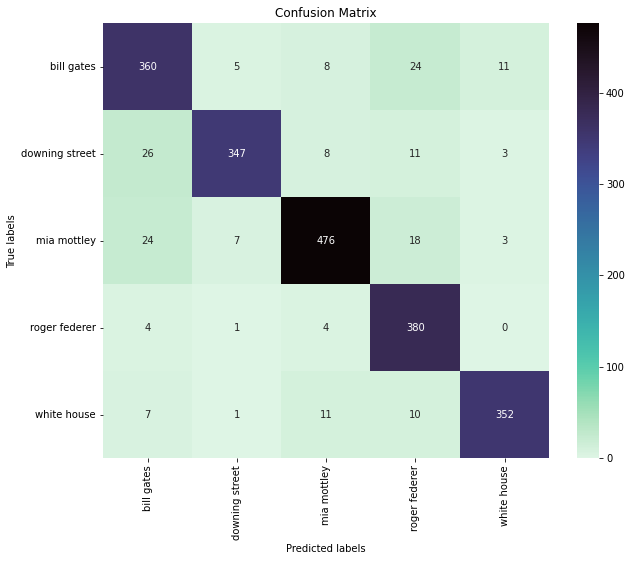

In [154]:
model = RandomForestClassifier(n_estimators=350, max_depth=132, max_features="log2")
model.fit(x_train_emb, y_train_emb)

y_pred = model.predict(x_test_emb)
evaluate(y_test_emb, y_pred)

**Task 4**

Q1: Which model performed best and why do you think that is? 

A1: In our tests, the Random Forest (RF) ensemble model with embeddings implemented produced the best performance for the authorship attribution problem, achieving an accuracy of 91% on our test set. We believe this is due to the resilience of the RF model to the issue of noise and outliers in our feature set.

Embedding the tweet data (i.e., producing a low-dimensional numerical representation of the tweets) with the “all-MiniLM-L6-v2” transformer model pairs nicely with the RF approach, since any noise that was left behind after embedding will be handled by the model. 

Furthermore, the RF model is resistant to overfitting because it averages the results of each tree at each iteration (reducing the overall variance while keeping the bias the same). 

The NN and kNN models, on the other hand, are not as resistant to overfitting (which is an issue due to the heavily contextual nature of the tweets and the overlap between our political account data (i.e., White House, Downing Street, etc.)).

Q2: Which features gave better results for each model? 

A2: In the case of our kNN model, the embedded features gave better results (a whopping 92% versus the 65% produced using the bag of words features). This is hardly surprising, seeing as the bag of words features are very sparse in nature. This makes it very difficult for the kNN model to perform well on them, since such models suffer from the curse of dimensionality (i.e., the issue that arises as a result of there being no "near" features). Hence, the kNN model performs many orders of magnitude better on the more dense embedded data.

In the case of our ensemble Random Forest (RF) model, the embeddings also gave much better results (and here, it was at least comparable with the bag of words features producing an accuracy of 90% vs. the 91% accuracy recorded using the embedded data). Using the tranformer model to embed our data effectively stores the *context* of each tweet in the feature set while also reducing the dimensionality of the data. This is, of course, vital for a use case as context-dependent as authorship attribution using scraped tweets, and this was reflected in the high accuracy that our RF model reported.

In the case of the NN model, however, we did observe that the embedded features performed to a lower degree of accuracy than the bag of words feature set. One possible explanation for this is that since the MLPClassifier has a number of parameters with many ranges in between, we could not run GridSearhCV or RandomizedSearchCV exhaustively (simply due to a shortage of time). 

Hence it is possible that we did not achieve the highest possible accuracy the Neural Network Model using embeddings. The current accuracy of about 90% for embedded data and 93% for the bag of words feature set is still considerable, however. To our surprise, the NN model was able to tackle the sparse bag of words feature set quite well. 

Q3: What effect would increasing the classes to 150 have?

A3: Adding more classes to the data can make the model more complex and can require more data to train the model accurately. This can make the training process more time-consuming and can also increase the risk of overfitting, where the model performs well on the training data but poorly on unseen data.

When working with a k-nearest neighbors (k-NN) predictive model, increasing the number of classes in the data would typically increase the complexity of the model, since the number of classes would require further computations.

In the case of the random forest,  increasing the number of classes in the data would not necessarily affect the performance of the random forest model, since the model is designed to handle multi-class classification problems. However, it is worth noting that increasing the number of classes would likely increase the complexity of the model, and might require more trees in the forest to achieve good performance. Additionally, the larger number of classes could potentially make it more challenging to interpret the predictions made by the model.

Finally, in the case of the NN model,  increasing the number of classes in the data would also typically increase the complexity of the model. This is because  the output layer of an NN model typically has one neuron for each class, and the neurons use a softmax activation function to produce a probability distribution over the classes. Increasing the number of classes to 150 would greatly increase the computation required. 

Q4: Suggest improvements to text preparation, feature extraction, and models that can be made
to perform this task better.

A4: Given more time, we would have liked to run the gridsearch cross validation function for our Neural Network model to exhaustively find the most suitable hyperparameters. 

We could also use more advanced techniques to tokenize the text and extract useful features, such as n-grams, and part-of-speech tags. These features can capture important information about the context and meaning of the words, possibly to a greater extent than our current embedded data does. 

We can also remove certain words that overlap across classes (since three of our classes have political contexts and hence would interfere with each other's classification (i.e., the White House, Downing Street, and Mia Mottley)). Ultimately, our goal is to carefully analyze the data and experiment with different approaches to find the best solution.

Q5: What - in your understanding - are the applications of authorship attribution?

A5:  In our understanding, authorship attribution is the process of identifying the author of a given text. 

This can be useful in a variety of contexts, such as in forensic linguistics to identify the author of an anonymous or pseudonymous document, or in the study of literature to attribute texts to specific authors. 

It can also be used to detect plagiarism by comparing the writing style of a given text to that of known authors. In general, authorship attribution can provide valuable insights into the relationship between language and identity.